In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.set()
import datetime

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import CustomJS, Slider, HoverTool, CategoricalColorMapper, WheelZoomTool, PanTool
hover = HoverTool()
from bokeh.palettes import brewer, Spectral11
output_notebook()

import os, sys
sys.path.append('/Users/joelelster/Python_projects/pybaseball/pybaseball/')
from statcast import statcast
from collections import Counter

Loading BokehJS ...

In [ ]:
# List of weird pitches

In [10]:
# grab all statcast data from 2018 to present day
statcast_2018_mlb = statcast('2018-03-24', '2018-04-10')

This is a large query, it may take a moment to complete
Completed sub-query from 2018-03-24 to 2018-03-29
Completed sub-query from 2018-03-30 to 2018-04-04
Completed sub-query from 2018-04-05 to 2018-04-10


In [28]:
# export data to csv so query wont need to be repeated over later
#statcast_2018_mlb.to_csv('./Data/statcast_2018.csv')

# read it in as well
#statcast_2018_mlb = pd.read_csv('./Data/statcast_2018.csv', index_col='index')

# duplicate the df so we can examine it without altering the original dataframe
df_master = statcast_2018_mlb # includes spring training

In [29]:
# Time to examine the data
df_master.shape

(59026, 88)

In [30]:
# Notice how there are a number of columns that are depreciated or all n/a
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59026 entries, 0 to 59025
Data columns (total 88 columns):
index                              59026 non-null int64
pitch_type                         53896 non-null object
game_date                          59026 non-null datetime64[ns]
release_speed                      53851 non-null float64
release_pos_x                      53848 non-null float64
release_pos_z                      53848 non-null float64
player_name                        59018 non-null object
batter                             59026 non-null float64
pitcher                            59026 non-null float64
events                             16409 non-null object
description                        59026 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated            0 non-null float64
zone                               5

In [32]:
# We want to drop columns where all values are null/na
df_master = df_master.dropna(axis=1,how='all')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59026 entries, 0 to 59025
Data columns (total 81 columns):
index                              59026 non-null int64
pitch_type                         53896 non-null object
game_date                          59026 non-null datetime64[ns]
release_speed                      53851 non-null float64
release_pos_x                      53848 non-null float64
release_pos_z                      53848 non-null float64
player_name                        59018 non-null object
batter                             59026 non-null float64
pitcher                            59026 non-null float64
events                             16409 non-null object
description                        59026 non-null object
zone                               53848 non-null float64
des                                16409 non-null object
game_type                          59026 non-null object
stand                              59026 non-null object
p_throws               

In [89]:
# looking at distribution of numeric columns
# get list of columns that are numeric
numeric_view_cols = []
for column in df_master.columns:
    col_type = df_master[column].dtype
    if col_type == 'float64':
        numeric_view_cols.append(column)
        
# there are a number of the columns that are more categorical than numeric (eg position ids)
drop_cols = ['game_year', 'pos2_person_id', 'game_pk', 'pos1_person_id', 'pos2_person_id.1',
            'pos3_person_id', 'pos4_person_id', 'pos5_person_id', 'pos6_person_id', 'pos7_person_id', 'pos8_person_id',
            'pos9_person_id', 'batter', 'pitcher'] 

# remove the columns
for col in drop_cols:
    numeric_view_cols.remove(col)

In [90]:
# create the numeric_df with only numeric columns
numeric_df = df_master[numeric_view_cols]
numeric_df.head()

,release_speed,release_pos_x,release_pos_z,zone,hit_location,balls,strikes,pfx_x,pfx_z,plate_x,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
0,95.1,-0.8800,6.1426,2.0,4.0,2.0,2.0,-0.4542,1.7025,0.1347,...,74.0,6.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
1,87.0,-0.6719,6.2139,14.0,NaN,1.0,2.0,0.5607,0.3139,1.0287,...,74.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
2,86.4,-0.9090,6.2035,8.0,NaN,1.0,2.0,0.3008,0.7419,0.2122,...,74.0,4.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
3,94.5,-0.8676,6.2574,8.0,NaN,1.0,1.0,-0.5225,1.7739,-0.1079,...,74.0,3.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
4,85.8,-0.7588,6.2371,14.0,NaN,1.0,0.0,0.5919,0.0648,1.3242,...,74.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0


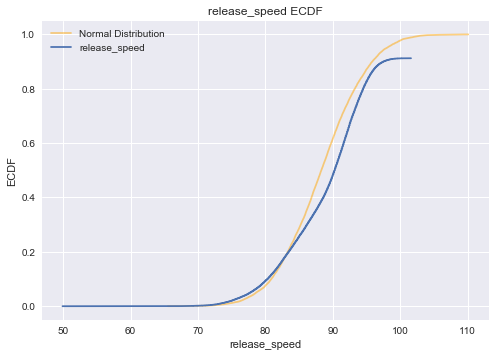

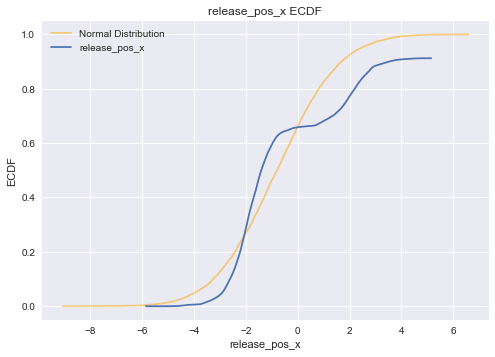

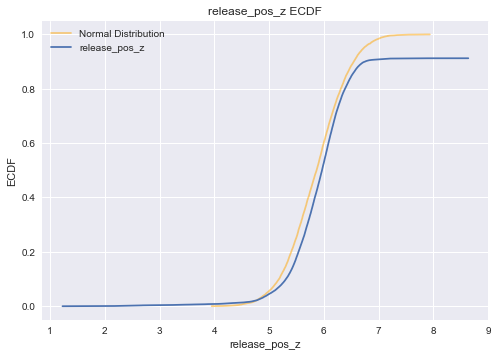

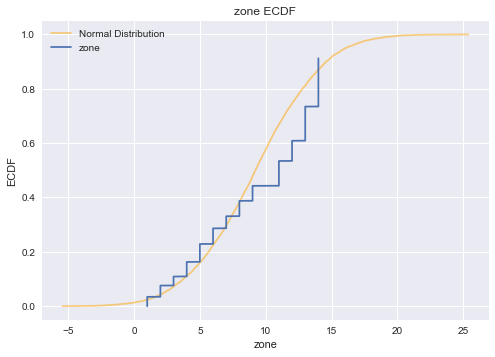

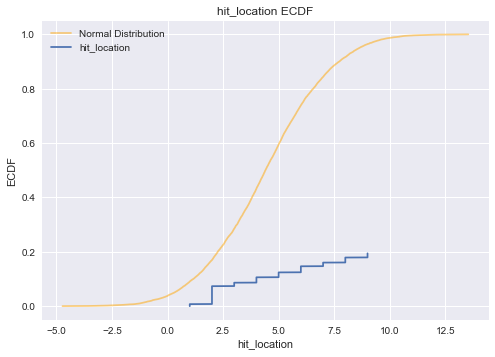

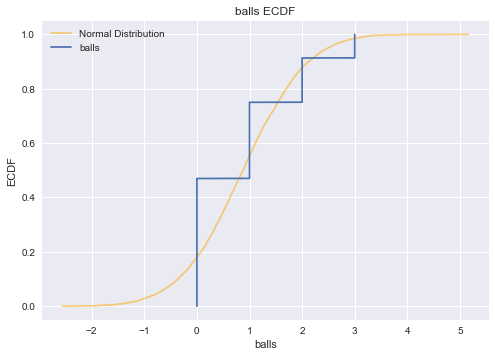

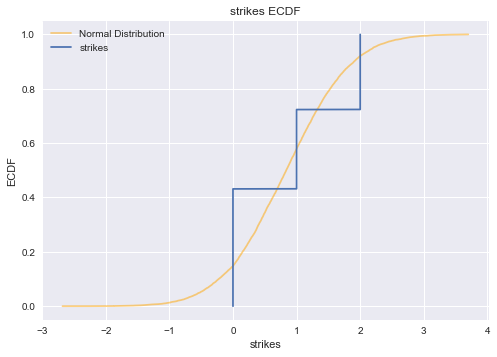

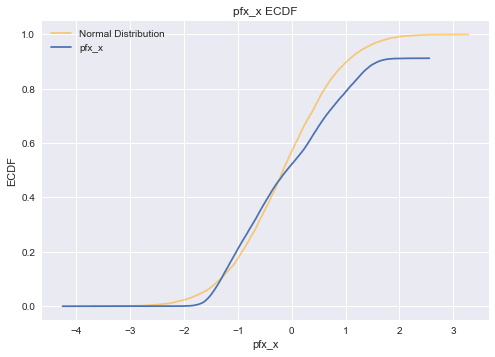

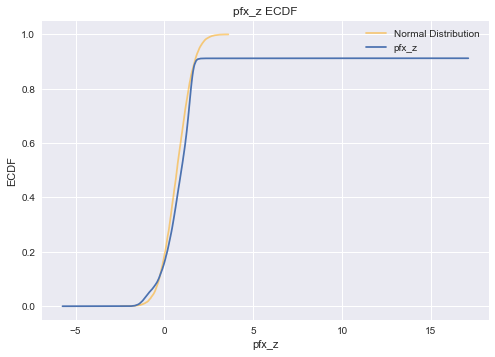

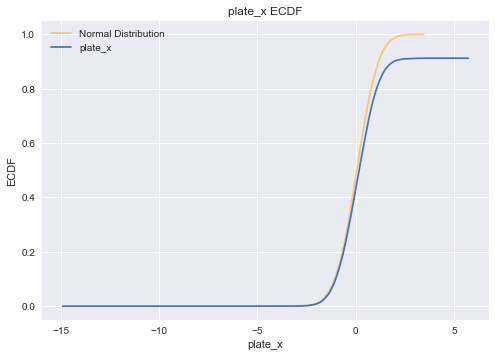

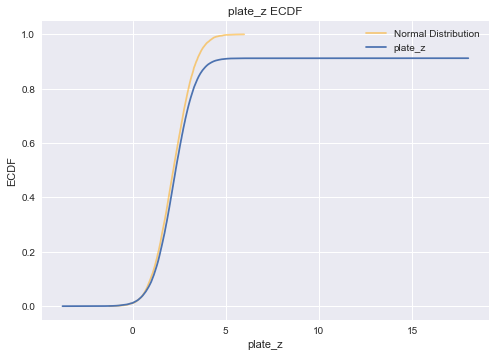

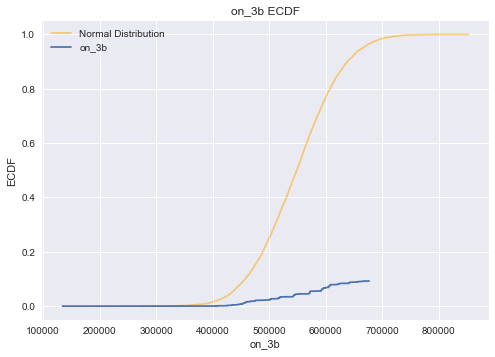

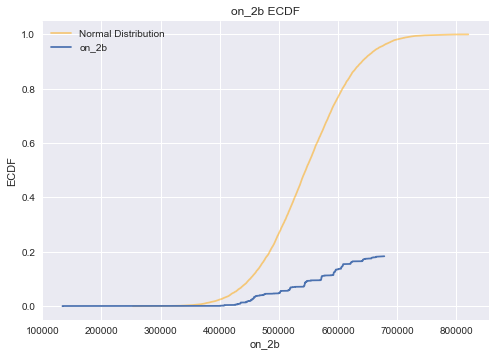

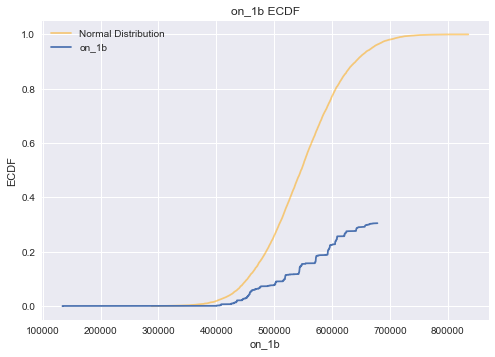

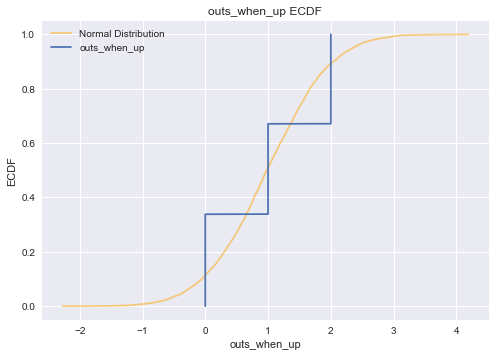

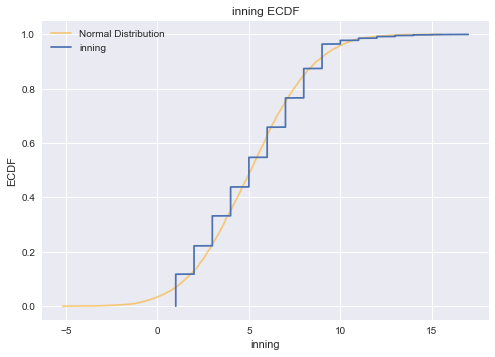

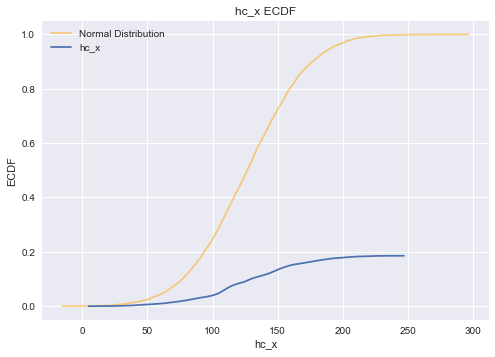

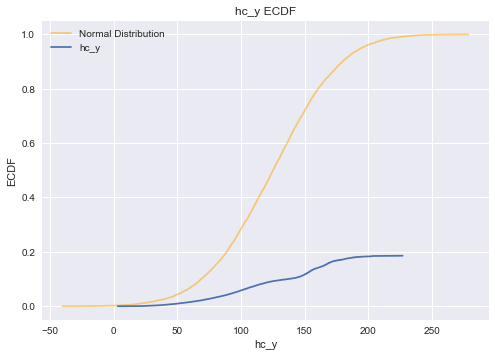

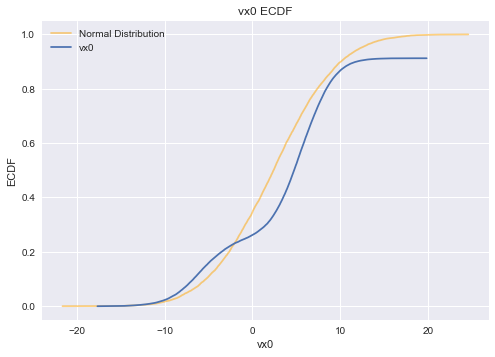

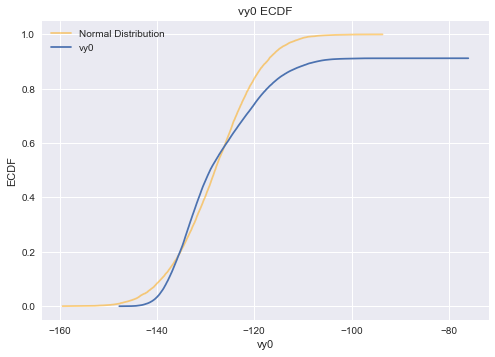

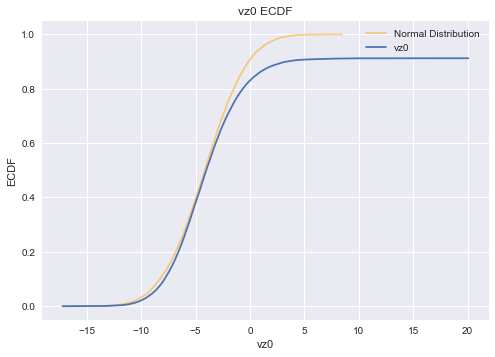

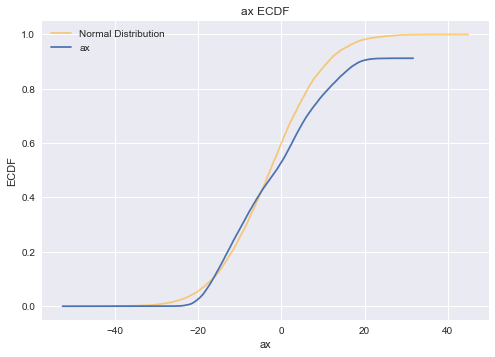

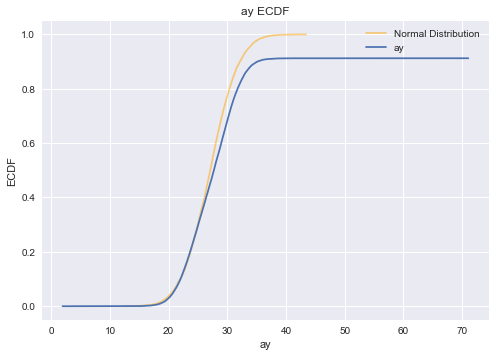

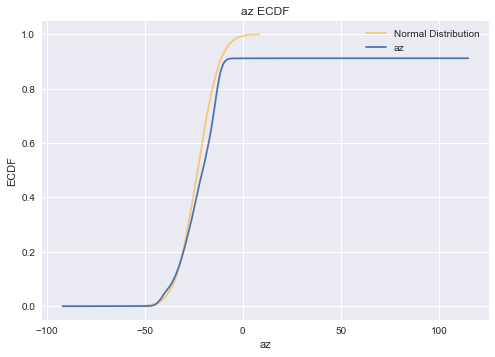

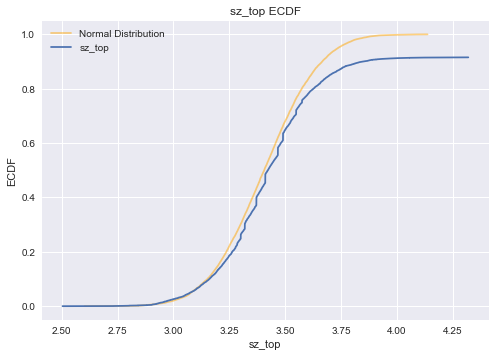

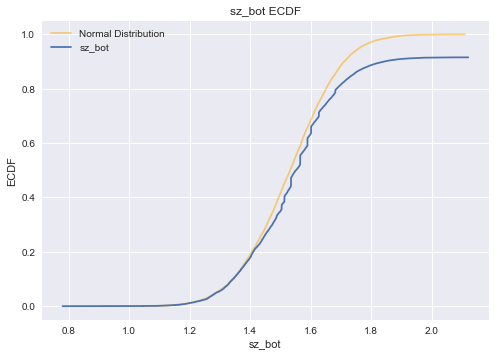

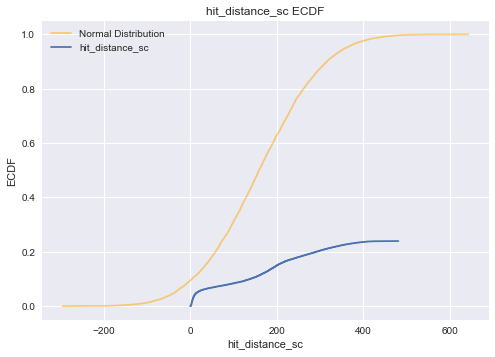

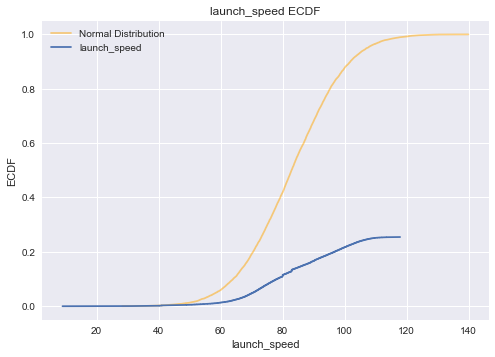

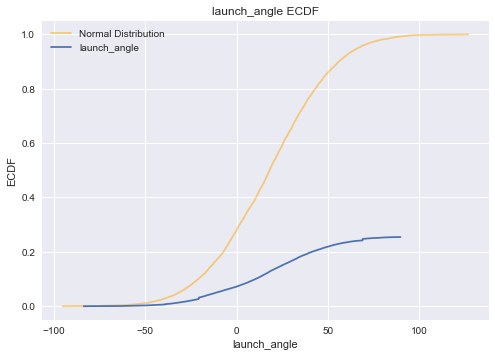

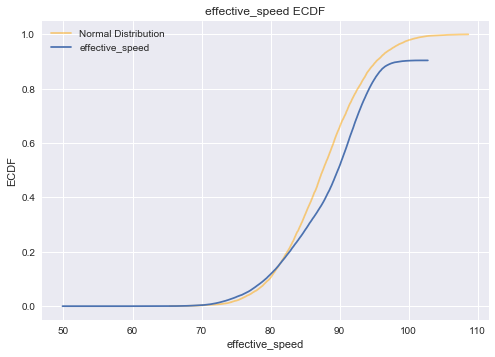

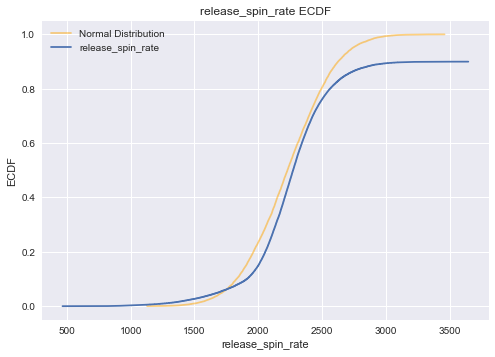

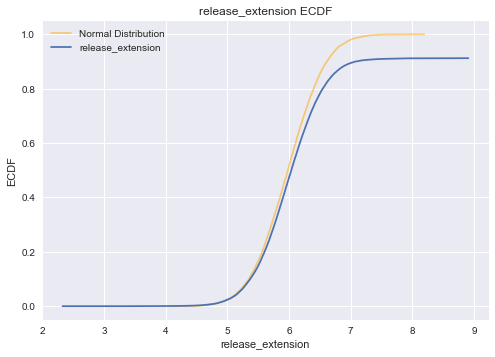

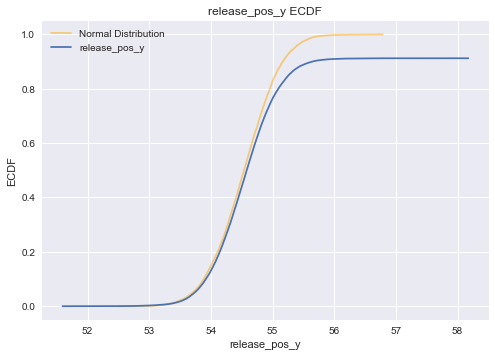

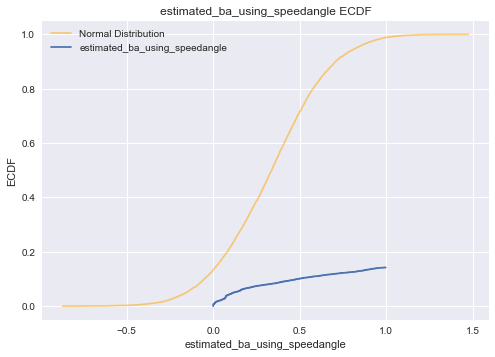

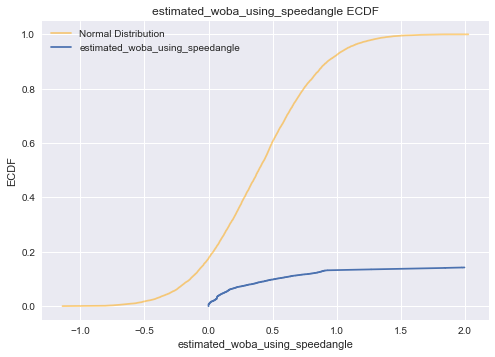

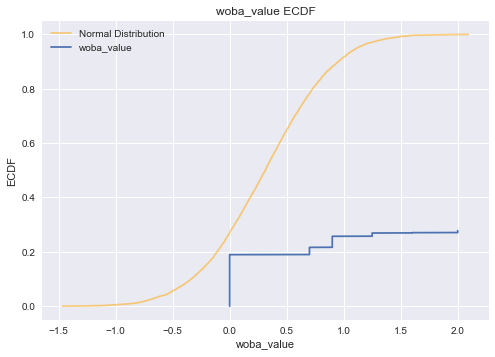

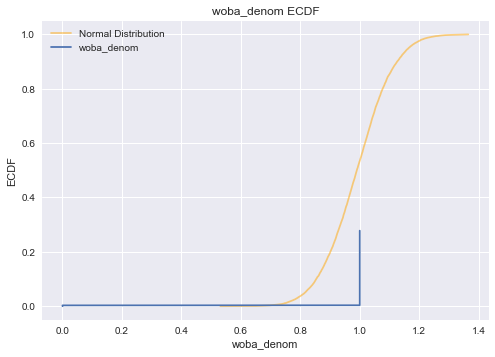

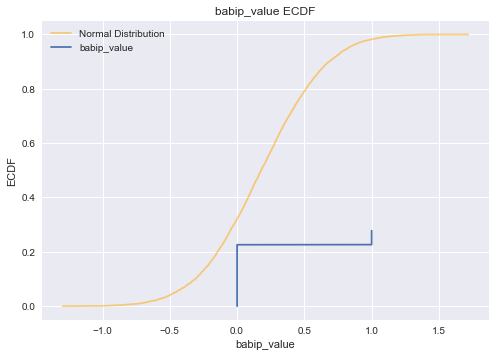

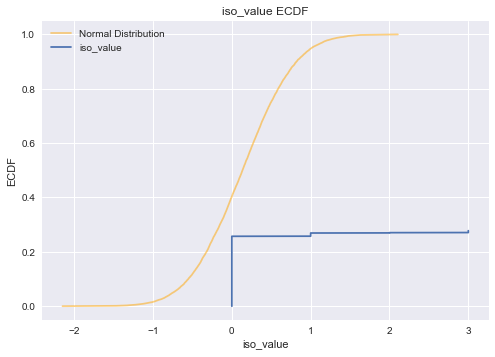

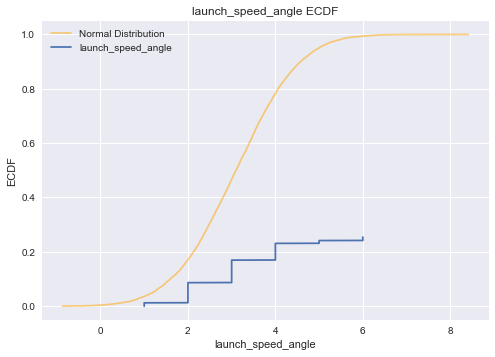

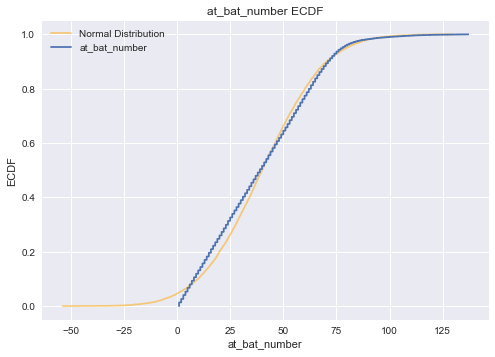

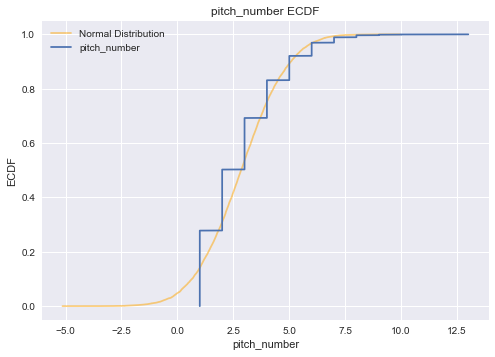

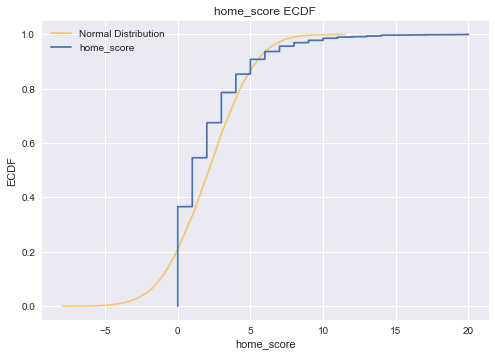

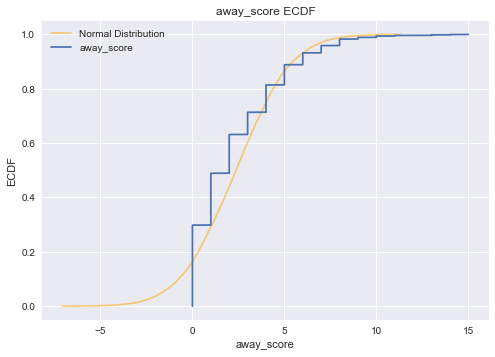

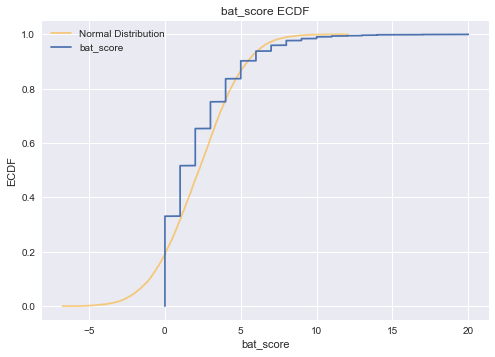

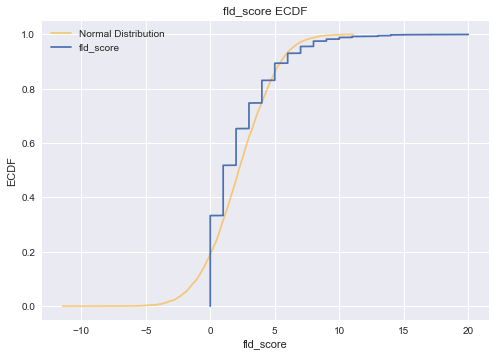

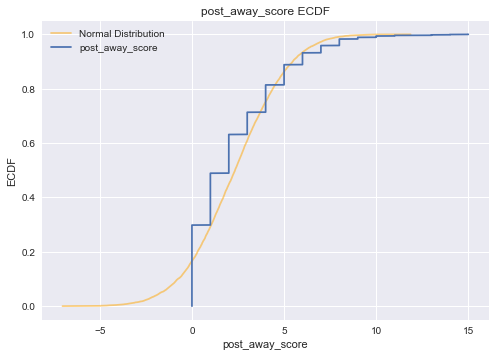

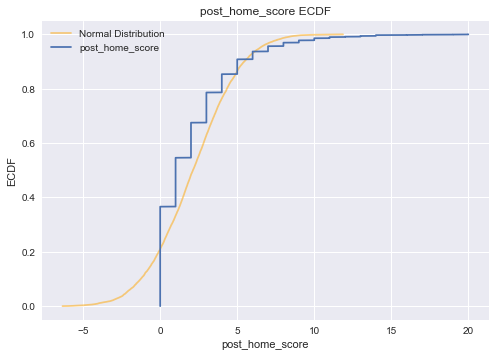

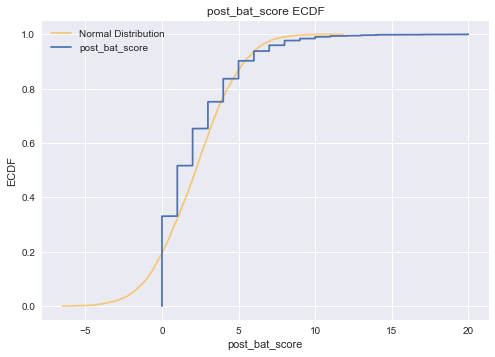

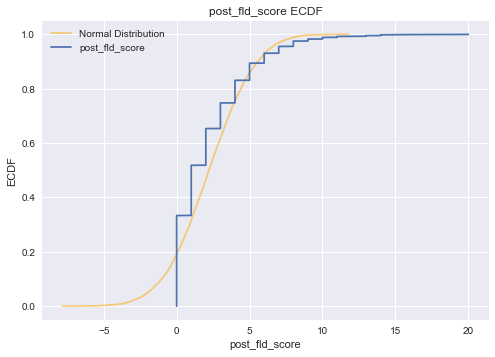

In [99]:
# check distribution for each column using ecdf function

# define ECDF to examine columns

#ecdf (see np_eda)
def ecdf(data, normal=True):
    """Compute ECDF for a one-dimensional array of measurements. x, y = ecdf(data)
    normal: add in predicted normal line
    """
    if normal == True:
        x_normal, y_normal = ecdf(np.random.normal(loc=data.mean(), scale=data.std(), size=10000), normal=False)
        _ = plt.plot(x_normal, y_normal, color = 'orange', alpha=0.5)    
    return np.sort(data), (np.arange(1, 1+ (len(data))) / (len(data))) 

# checking the data
for column in numeric_df.columns:
    x_vars, y_vars = ecdf(numeric_df[column])
    _ = plt.plot(x_vars, y_vars)
    _ = plt.title('{} ECDF'.format(column))
    _ = plt.ylabel('ECDF')
    _ = plt.xlabel(column)
    _ = plt.legend(['Normal Distribution', column])
    plt.show()

In [107]:
# Looking to see which columns are correlated to each other
numeric_df.corr()

,release_speed,release_pos_x,release_pos_z,zone,hit_location,balls,strikes,pfx_x,pfx_z,plate_x,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
release_speed,1.000000,-0.112245,0.076439,-0.148899,0.075961,0.093432,-0.038335,-0.278911,0.733848,-0.027259,...,0.047436,0.034858,0.028636,0.032785,-0.000348,0.060441,0.032801,0.028636,-0.000333,0.060441
release_pos_x,-0.112245,1.000000,0.129924,0.001178,-0.012326,0.006879,0.008044,0.421753,0.001911,0.009761,...,-0.041637,0.009983,-0.044367,0.001426,-0.016166,-0.028324,0.001418,-0.044367,-0.016174,-0.028324
release_pos_z,0.076439,0.129924,1.000000,-0.018108,0.053107,-0.010650,-0.026175,0.027380,0.144218,0.013775,...,-0.139044,-0.024303,-0.061862,-0.071258,-0.104379,-0.029427,-0.071257,-0.061862,-0.104378,-0.029427
zone,-0.148899,0.001178,-0.018108,1.000000,-0.283222,-0.067366,0.069509,0.046800,-0.169124,0.177940,...,0.006940,-0.001595,0.002268,0.002032,0.010990,-0.006388,0.002038,0.002268,0.010997,-0.006388
hit_location,0.075961,-0.012326,0.053107,-0.283222,1.000000,-0.063608,-0.409399,-0.038016,0.135901,-0.047212,...,-0.016938,-0.254448,0.008940,0.002749,0.007555,0.004399,0.002749,0.008940,0.007555,0.004399
balls,0.093432,0.006879,-0.010650,-0.067366,-0.063608,1.000000,0.360338,-0.016492,0.071735,-0.012753,...,0.005782,0.817317,0.000520,0.007583,0.008092,-0.000097,0.007571,0.000520,0.008080,-0.000097
strikes,-0.038335,0.008044,-0.026175,0.069509,-0.409399,0.360338,1.000000,0.036268,-0.088131,0.032161,...,-0.004159,0.784994,-0.010366,-0.012015,-0.019361,-0.003195,-0.012029,-0.010366,-0.019375,-0.003195
pfx_x,-0.278911,0.421753,0.027380,0.046800,-0.038016,-0.016492,0.036268,1.000000,-0.212966,0.259868,...,0.002151,0.011072,-0.005179,0.021947,0.006786,0.008830,0.021928,-0.005179,0.006767,0.008830
pfx_z,0.733848,0.001911,0.144218,-0.169124,0.135901,0.071735,-0.088131,-0.212966,1.000000,-0.038529,...,-0.001500,-0.007687,-0.000022,0.002521,0.000404,0.001962,0.002531,-0.000022,0.000414,0.001962
plate_x,-0.027259,0.009761,0.013775,0.177940,-0.047212,-0.012753,0.032161,0.259868,-0.038529,1.000000,...,0.007124,0.008255,0.000385,0.011055,0.006293,0.004726,0.011020,0.000385,0.006259,0.004726


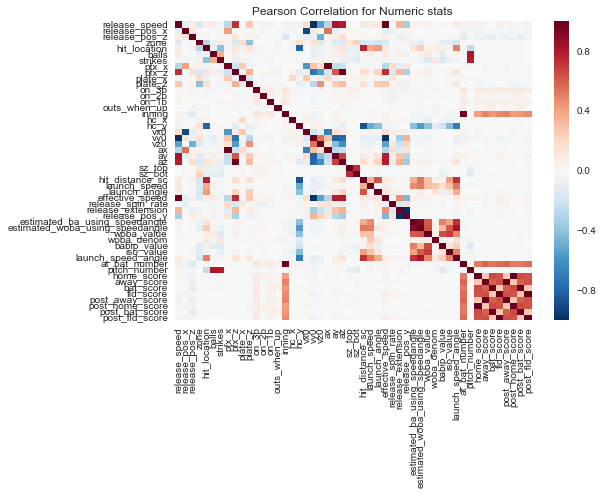

In [101]:
# Visualizing as a heatmap
_ = sns.heatmap(numeric_df.corr())
_ = plt.title('Pearson Correlation for Numeric stats ')
plt.show()

In [132]:
# grabbing a list of correlations over 0.75 or under -0.75
correlated_dict = dict()

for col_outer in numeric_df.columns:
    col1 = numeric_df[col_outer]
    for col_inner in numeric_df:
        col2 = numeric_df[col_inner]
        #print(col_outer, 'vs', col_inner)
        #print(col1.corr(col2))
        corr_score = col1.corr(col2)
        if (abs(corr_score) > 0.75) & (abs(corr_score) < 0.99):
            try: # to prevent a:b and b:a
                col_outer in correlated_dict[col_inner]
            except KeyError:
                correlated_dict[col_outer] = col_inner

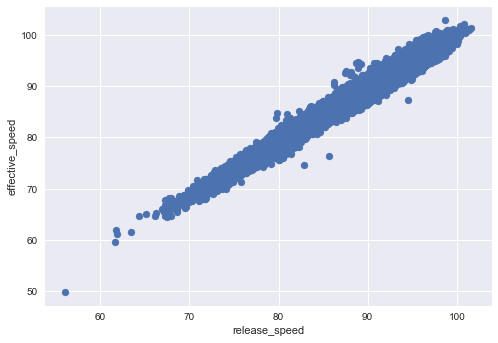

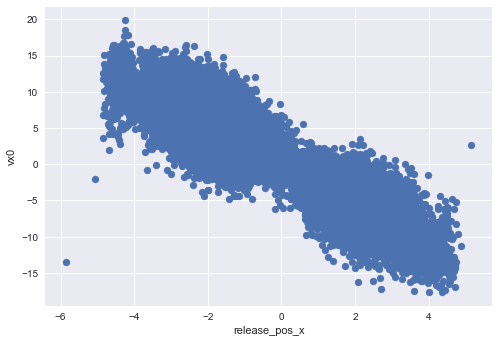

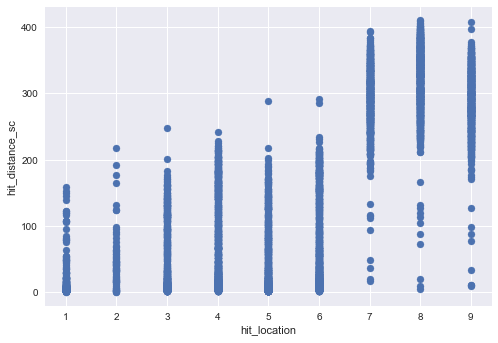

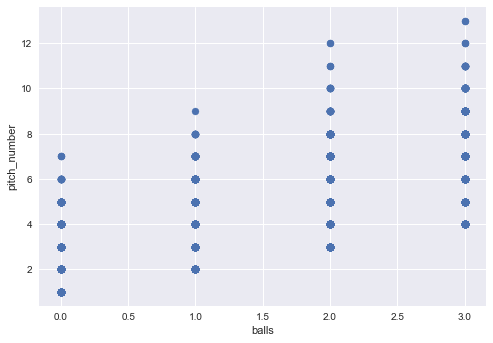

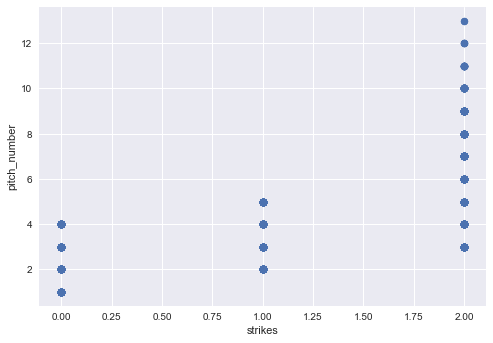

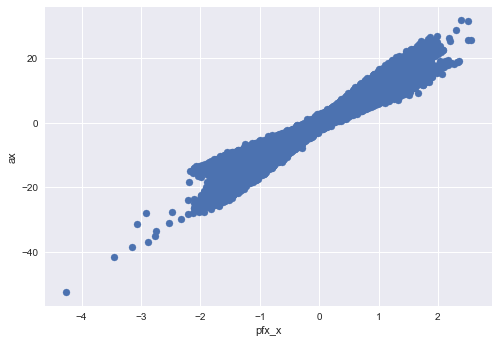

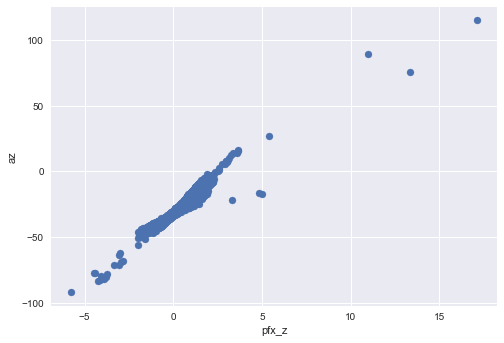

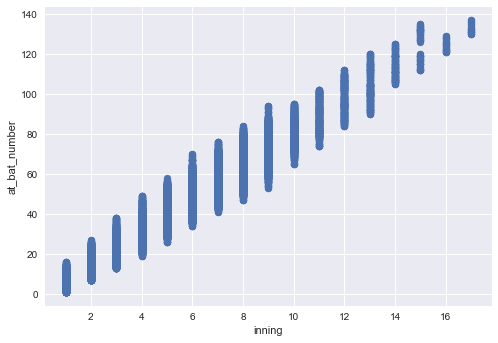

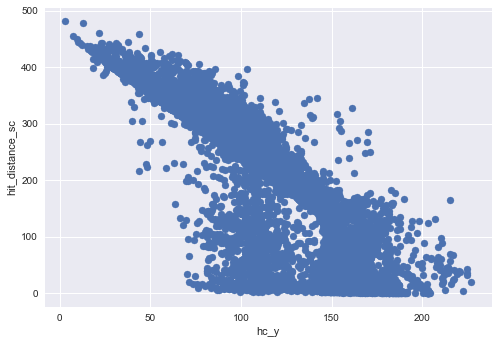

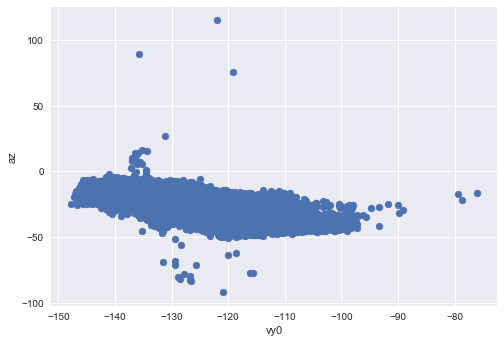

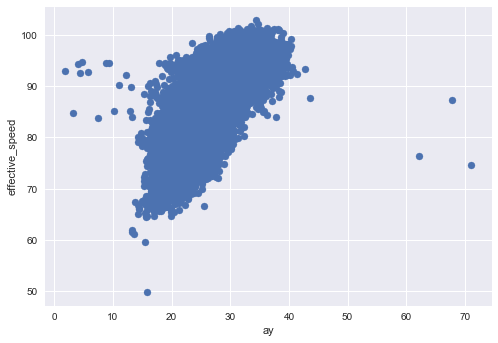

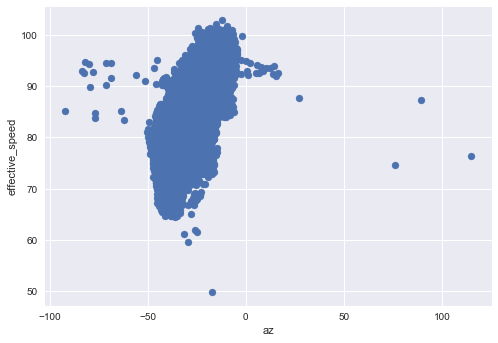

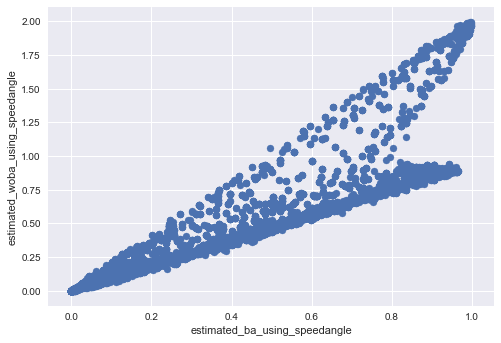

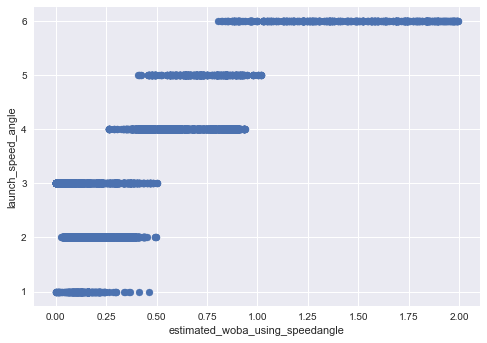

In [138]:
for key, value in correlated_dict.items():
    _ = plt.scatter(numeric_df[key], numeric_df[value])
    _ = plt.xlabel(key)
    _ = plt.ylabel(value)
    _ = plt.show()

# Thoughts on correlations:
effective speed v release speed - not surprising- what is the difference?
vx0 v release_pos_x - what is vx0? are they the same thing?
hit location v hit_distance_sc (ft?) 
balls/strikes v pitch number
pfx_x v ax (what are they)
pfx_z v az (a few strange data points)
inning/ab 
hc_y v hit_distance_sc
estimated ba using speedangle v estimated woba using speed_angle - line with an extra stretch




In [398]:
# Look at hanging pitches
# question: does hit speed/ba/estimated woba/etc. change for low quality v high quality pitches
# high leverage/low leverage pitch counts?
# df of pitches w/ data from regular season
df = df_master[(df_master.pfx_x.notnull()) & (df_master.pfx_z.notnull())]
df = df[df.game_type == 'R'] # fliter out spring training
rhp_rhb_df = df[df.p_throws == 'R']
rhp_rhb_df = df[df.stand == 'R']
rhp_rhb_df = rhp_rhb_df.set_index('pitch_name')

# min 1000 pitches (or 400)
pitch_list = [(x, len(rhp_rhb_df.loc[x])) for x in rhp_rhb_df.index.unique()]
cleaned_list = []
for pitch,count in pitch_list:
    if count > 400:
        cleaned_list.append(pitch)

# define bad pitches and good pitches, add to df
hq_pitch_df = pd.DataFrame()
hanging_pitch_df = pd.DataFrame()
medium_pitch_df = pd.DataFrame()

for pitch in cleaned_list:
    # take percentile of movement. NEED TO DEFINE WHICH PITCHES RISE/SINK
    df = rhp_rhb_df.loc[pitch]
    x = df.pfx_x
    z = df.pfx_z
    if np.mean(x) > 0: # if +x movement is good
        low_x, high_x = np.percentile(x, [25,75])
    else: # if -x movement is good, reverse it
        df.pfx_x = df.pfx_x * -1
        low_x, high_x = np.percentile(x, [25,75])
    if np.mean(z) < 0: # if +z is good
        low_z, high_z = np.percentile(z, [25,75])
    else: # if -z is good
        df.pfx_z = df.pfx_z * -1
        low_z, high_z = np.percentile(z, [25,75])
    
    # breaking pitches into hq, hanging, and medium. not perfect

    hq_pitch = df[(df.pfx_x > high_x) & (df.pfx_z > high_z)]
    hanging = df[(df.pfx_x < low_x) & (df.pfx_z < low_z)]
    medium = df[((df.pfx_x > high_x) & (df.pfx_z < high_z)) | ((df.pfx_x < high_x) & (df.pfx_z > high_z)) |
               ((df.pfx_x < low_x) & (df.pfx_z > low_z) )| ((df.pfx_x > low_x) & (df.pfx_z < low_z))]    
    
    # adding them onto the others
    hq_pitch_df = pd.concat([hq_pitch_df, hq_pitch])
    hanging_pitch_df = pd.concat([hanging_pitch_df, hanging])
    medium_pitch_df = pd.concat([medium_pitch_df, medium])


In [452]:
print('RHP TO RHB')
print('HQ Pitches')
print('K Rate:',len(hq_pitch_df[hq_pitch_df.events == 'strikeout']) / len(hq_pitch_df))
print('HR Rate:',len(hq_pitch_df[hq_pitch_df.events == 'home_run']) / len(hq_pitch_df))
print('BB Rate:',len(hq_pitch_df[hq_pitch_df.events == 'walk']) / len(hq_pitch_df))
print('Median woba:', hq_pitch_df[hq_pitch_df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', hq_pitch_df[hq_pitch_df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', hq_pitch_df[hq_pitch_df.launch_speed.notnull()].launch_speed.median())


print('\nHanging Pitches')
print('K Rate:',len(hanging_pitch_df[hanging_pitch_df.events == 'strikeout']) / len(hanging_pitch_df))
print('HR Rate:',len(hanging_pitch_df[hanging_pitch_df.events == 'home_run']) / len(hanging_pitch_df))
print('BB Rate:',len(hanging_pitch_df[hanging_pitch_df.events == 'walk']) / len(hanging_pitch_df))
print('Median woba:', hanging_pitch_df[hanging_pitch_df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', hanging_pitch_df[hanging_pitch_df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', hanging_pitch_df[hanging_pitch_df.launch_speed.notnull()].launch_speed.median())


print('\nMedium Pitches')
print('K Rate:',len(medium_pitch_df[medium_pitch_df.events == 'strikeout']) / len(medium_pitch_df))
print('HR Rate:',len(medium_pitch_df[medium_pitch_df.events == 'home_run']) / len(medium_pitch_df))
print('BB Rate:',len(medium_pitch_df[medium_pitch_df.events == 'walk']) / len(medium_pitch_df))
print('Median woba:', medium_pitch_df[medium_pitch_df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', medium_pitch_df[medium_pitch_df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', medium_pitch_df[medium_pitch_df.launch_speed.notnull()].launch_speed.median())


RHP TO RHB
HQ Pitches
K Rate: 0.05454545454545454
HR Rate: 0.004434589800443459
BB Rate: 0.02394678492239468
Median woba: 0.20600000000000002
Median LA: 9.292
Median Speed: 82.4

Hanging Pitches
K Rate: 0.061931818181818185
HR Rate: 0.00909090909090909
BB Rate: 0.02159090909090909
Median woba: 0.2975
Median LA: 22.5754
Median Speed: 81.1

Medium Pitches
K Rate: 0.05899802241265656
HR Rate: 0.0063722258844210065
BB Rate: 0.02032520325203252
Median woba: 0.23600000000000002
Median LA: 18.248649999999998
Median Speed: 82.3


In [453]:
p = figure(x_axis_label = 'Launch Angle', y_axis_label='Launch Speed', title='RHP to RHB')
p.circle(x=hq_pitch_df.launch_angle, y=hq_pitch_df.launch_speed)
p.x(x=hanging_pitch_df.launch_angle, y=hanging_pitch_df.launch_speed, color='red')
#p.triangle(x=medium_pitch_df.launch_angle, y=medium_pitch_df.launch_speed, color='green', alpha=0.4)
show(p)

In [461]:
hanging_pitch_df.index.unique()

Index(['Changeup', 'Cutter', 'Curveball', 'Slider', '2-Seam Fastball',
       'Sinker', '4-Seam Fastball', 'Split Finger', 'Knuckle Curve'],
      dtype='object', name='pitch_name')

In [462]:
print('RHP TO RHB Curveballs')
print('HQ Pitches')
df = hq_pitch_df.loc['Curveball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())


print('\nHanging Pitches')
df = hanging_pitch_df.loc['Curveball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())


print('\nMedium Pitches')
df = medium_pitch_df.loc['Curveball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())

RHP TO RHB Curveballs
HQ Pitches
K Rate: 0.08426966292134831
HR Rate: 0.0
BB Rate: 0.011235955056179775
Median woba: 0.20800000000000002
Median LA: 22.595
Median Speed: 68.1

Hanging Pitches
K Rate: 0.08097165991902834
HR Rate: 0.004048582995951417
BB Rate: 0.012145748987854251
Median woba: 0.282
Median LA: 3.5404999999999998
Median Speed: 83.1

Medium Pitches
K Rate: 0.06856754921928038
HR Rate: 0.0033944331296673455
BB Rate: 0.011541072640868975
Median woba: 0.1655
Median LA: 12.2645
Median Speed: 81.7


In [ ]:
print('RHP TO RHB Four Seamers')
print('HQ Pitches')
df = hq_pitch_df.loc['4-Seam Fastball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())


print('\nHanging Pitches')
df = hanging_pitch_df.loc['4-Seam Fastball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())


print('\nMedium Pitches')
df = medium_pitch_df.loc['4-Seam Fastball']
print('K Rate:',len(df[df.events == 'strikeout']) / len(df))
print('HR Rate:',len(df[df.events == 'home_run']) / len(df))
print('BB Rate:',len(df[df.events == 'walk']) / len(df))
print('Median woba:', df[df.estimated_woba_using_speedangle.notnull()].estimated_woba_using_speedangle.median())
print('Median LA:', df[df.launch_angle.notnull()].launch_angle.median())
print('Median Speed:', df[df.launch_speed.notnull()].launch_speed.median())

In [ ]:
# guessin woba from movement


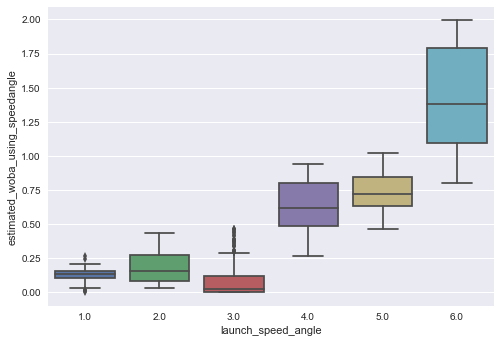

In [471]:
_ = sns.boxplot(x='launch_speed_angle',y='estimated_woba_using_speedangle',data=df)
plt.show()

array([  nan, 0.286, 0.072, 0.168, 0.215, 0.606, 0.454, 0.74 , 0.436,
       0.013, 0.363, 0.   , 0.002, 0.463, 0.854, 0.045, 0.122, 0.365,
       0.234, 0.634, 0.227, 0.061, 0.502, 0.043, 0.729, 0.768, 0.581,
       0.245, 0.029, 0.547, 0.963, 0.088, 0.09 , 0.427, 0.018, 0.393,
       0.309, 0.152, 0.093, 0.836, 0.334, 0.44 , 0.354, 0.181, 0.015,
       0.159, 0.297, 0.386, 0.004, 0.693, 0.006, 0.861, 0.156, 0.918,
       0.32 , 0.143, 0.665, 0.9  , 0.138, 0.415, 0.2  , 0.661, 0.118,
       0.538, 0.99 , 0.922, 0.372, 0.445, 0.815, 0.452, 0.781, 0.888,
       0.079, 0.054, 0.654, 0.943, 0.475, 0.995, 0.04 , 0.077, 0.009,
       0.556, 0.479, 0.05 , 0.643, 0.604, 0.65 , 0.704, 0.211, 0.961,
       0.161, 0.615, 0.106, 0.102, 0.64 , 0.1  , 0.256, 0.14 , 0.881,
       0.195, 0.056, 0.243, 0.027, 0.884, 0.281, 0.304, 0.384, 0.109,
       0.706, 0.02 , 0.468, 0.57 , 0.336, 0.247, 0.988, 0.343, 0.329,
       0.497, 0.872, 0.911, 0.736, 0.125, 0.036, 0.838, 0.954, 0.084,
       0.197, 0.065,

https://s3.amazonaws.com/assets.datacamp.com/production/project_250/img/zone.png

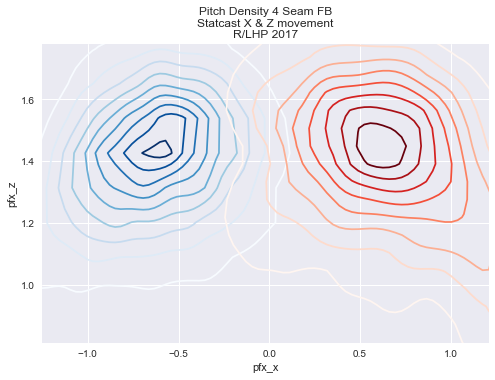

In [226]:
# side project
# set df to not null pfx_x and pfx_z pitches
df = df_master[(df_master.pfx_x.notnull()) & (df_master.pfx_z.notnull())]
df = df[df.game_type == 'R'] # fliter out spring training
df = df[df.pitch_name == '4-Seam Fastball']
df_r = df[df.p_throws == 'R'] # RHP
df_l = df[df.p_throws == 'L'] # LHP

# plotting
# grabbing min/max for axis 
x_min, x_max = np.percentile(df.pfx_x, [3,97])
y_min, y_max = np.percentile(df.pfx_z, [3,97])

# plotting the distributions
_ = sns.kdeplot(data=df_r.pfx_x, data2=df_r.pfx_z, fit_reg=True, shade=False, shade_lowest=False,cmap='Blues').set_title('Pitch Density 4 Seam FB\nStatcast X & Z movement\nR/LHP 2018')
_ = sns.kdeplot(data=df_l.pfx_x, data2=df_l.pfx_z, fit_reg=True, shade=False, shade_lowest=False,cmap='Reds')
_ = plt.axis([x_min, x_max, y_min, y_max])
plt.show()

Cutter
Changeup
Slider
4-Seam Fastball
Curveball
2-Seam Fastball
Sinker
Screwball
not enough pitches to plot
Knuckle Curve
Split Finger
Pitch Out
not enough pitches to plot
Forkball
not enough pitches to plot
Eephus
not enough pitches to plot


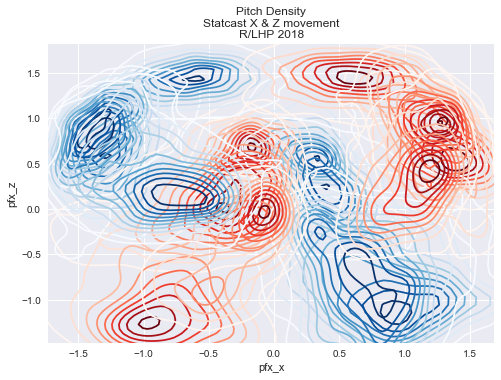

In [281]:
df = df_master[(df_master.pfx_x.notnull()) & (df_master.pfx_z.notnull())]
df = df[df.game_type == 'R'] # fliter out spring training
x_min, x_max = np.percentile(df.pfx_x, [0.75,99.25])
y_min, y_max = np.percentile(df.pfx_z, [0.75,99.25])
unique_pitches = df_master.pitch_name.unique()
cleaned_pitches = [x for x in unique_pitches if str(x) != 'nan']

for pitch_name in cleaned_pitches:
    print(pitch_name)
    # make sure there are enough pitches to plot
    if len(df[df.pitch_name == pitch_name]) > 300:
        # set df to not null pfx_x and pfx_z pitches
        df_inner = df[df.pitch_name == pitch_name]
        df_r = df_inner[df_inner.p_throws == 'R'] # RHP
        df_l = df_inner[df_inner.p_throws == 'L'] # LHP 

        # plotting the distributions
        _ = sns.kdeplot(data=df_r.pfx_x, data2=df_r.pfx_z, fit_reg=True, shade=False, shade_lowest=False,cmap='Blues').set_title('Pitch Density\nStatcast X & Z movement\nR/LHP 2018')
        _ = sns.kdeplot(data=df_l.pfx_x, data2=df_l.pfx_z, fit_reg=True, shade=False, shade_lowest=False,cmap='Reds')
    else:
        print('not enough pitches to plot')

_ = plt.axis([x_min, x_max, y_min, y_max])
plt.show()

In [279]:
df[df.pitch_name == pitch_name]

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
355,775,SC,2018-04-10,79.8,2.3853,5.8225,Hector Santiago,621002.0,502327.0,NaN,...,1.0,Screwball,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0
373,1043,SC,2018-04-10,79.4,2.0684,5.8071,Hector Santiago,467092.0,502327.0,NaN,...,1.0,Screwball,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0
15391,13935,SC,2018-04-07,80.6,2.3574,5.7716,Hector Santiago,543510.0,502327.0,field_out,...,1.0,Screwball,0.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0
29411,4085,SC,2018-04-03,80.2,2.2334,5.6561,Hector Santiago,571912.0,502327.0,NaN,...,2.0,Screwball,7.0,5.0,7.0,5.0,5.0,7.0,7.0,5.0
29412,4096,SC,2018-04-03,79.4,2.2360,5.8208,Hector Santiago,571912.0,502327.0,NaN,...,1.0,Screwball,7.0,5.0,7.0,5.0,5.0,7.0,7.0,5.0
29462,4698,SC,2018-04-03,80.2,2.1450,5.6439,Hector Santiago,500208.0,502327.0,NaN,...,2.0,Screwball,7.0,4.0,7.0,4.0,4.0,7.0,7.0,4.0


In [271]:
for x in unique_pitches:
    print(x)

Cutter
Changeup
Slider
4-Seam Fastball
Curveball
nan
2-Seam Fastball
Sinker
Screwball
Knuckle Curve
Split Finger
Pitch Out
Forkball
Eephus
